**Introduction**<br>
There's more to the world of deep learning than just dense layers. There are dozens of kinds of layers you might add to a model. (Try browsing through the [Keras docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/) for a sample!) Some are like dense layers and define connections between neurons, and others can do preprocessing or transformations of other sorts.

In this lesson, we'll learn about a two kinds of special layers, not containing any neurons themselves, but that add some functionality that can sometimes benefit a model in various ways. Both are commonly used in modern architectures.

**Dropout**<br>
The first of these is the "dropout layer", which can help correct overfitting.

In the last lesson we talked about how overfitting is caused by the network learning spurious patterns in the training data. To recognize these spurious patterns a network will often rely on very a specific combinations of weight, a kind of "conspiracy" of weights. Being so specific, they tend to be fragile: remove one and the conspiracy falls apart.

This is the idea behind dropout. To break up these conspiracies, we randomly drop out some fraction of a layer's input units every step of training, making it much harder for the network to learn those spurious patterns in the training data. Instead, it has to search for broad, general patterns, whose weight patterns tend to be more robust.

<center><img src="https://storage.googleapis.com/kaggle-media/learn/images/a86utxY.gif" width="600" alt="An animation of a network cycling through various random dropout configurations."></center>
<center>Here, 50% dropout has been added between the two hidden layers.</center>

<br>

**Adding Dropout**<br>
In Keras, the dropout rate argument rate defines what percentage of the input units to shut off. Put the Dropout layer just before the layer you want the dropout applied to:
<pre><code>keras.Sequential([
    # ...
    layers.Dropout(rate=0.3), # apply 30% dropout to the next layer
    layers.Dense(16),
    # ...
])</code></pre>

<br>

**Batch Normalization**<br>
The next special layer we'll look at performs "batch normalization" (or "batchnorm"), which can help correct training that is slow or unstable.

With neural networks, it's generally a good idea to put all of your data on a common scale, perhaps with something like scikit-learn's [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) or [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). The reason is that SGD will shift the network weights in proportion to how large an activation the data produces. Features that tend to produce activations of very different sizes can make for unstable training behavior.

Now, if it's good to normalize the data before it goes into the network, maybe also normalizing inside the network would be better! In fact, we have a special kind of layer that can do this, the batch normalization layer. A batch normalization layer looks at each batch as it comes in, first normalizing the batch with its own mean and standard deviation, and then also putting the data on a new scale with two trainable rescaling parameters. Batchnorm, in effect, performs a kind of coordinated rescaling of its inputs.

Most often, batchnorm is added as an aid to the optimization process (though it can sometimes also help prediction performance). Models with batchnorm tend to need fewer epochs to complete training. Moreover, batchnorm can also fix various problems that can cause the training to get "stuck". Consider adding batch normalization to your models, especially if you're having trouble during training.

<br>

**Adding Batch Normalization**<br>
It seems that batch normalization can be used at almost any point in a network. You can put it after a layer...

<pre><code>layers.Dense(16, activation='relu'),
layers.BatchNormalization(),</code></pre>

... or between a layer and its activation function:

<pre><code>layers.Dense(16),
layers.BatchNormalization(),
layers.Activation('relu'),</code></pre>

And if you add it as the first layer of your network it can act as a kind of adaptive preprocessor, standing in for something like Sci-Kit Learn's StandardScaler.


<br>

**Example - Using Dropout and Batch Normalization**<br>
Let's continue developing the *Red Wine* model. Now we'll increase the capacity even more, but add dropout to control overfitting and batch normalization to speed up optimization. This time, we'll also leave off standardizing the data, to demonstrate how batch normalization can stabalize the training.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

# Create validation and training split
df = pd.read_csv("./resources/datasets/red-wine.csv")
df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)


# Split features and target
X_train = df_train.drop(columns=['quality'])
X_valid = df_valid.drop(columns=['quality'])
y_train = df_train['quality']
y_valid = df_valid['quality']

When adding dropout, you may need to increase the number of units in your Dense layers.

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=[11]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu', input_shape=[11]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu', input_shape=[11]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1)
])

There's nothing to change this time in how we set up the training.


Epoch 1/200

5/5 [==============================] - 4s 181ms/step - loss: 5.5532 - val_loss: 9.9055
Epoch 2/200
5/5 [==============================] - 0s 83ms/step - loss: 5.3474 - val_loss: 3.6373
Epoch 3/200
5/5 [==============================] - 0s 89ms/step - loss: 5.1449 - val_loss: 6.1592
Epoch 4/200
5/5 [==============================] - 0s 85ms/step - loss: 4.8954 - val_loss: 3.3802
Epoch 5/200
5/5 [==============================] - 0s 86ms/step - loss: 4.6334 - val_loss: 11.5242
Epoch 6/200
5/5 [==============================] - 0s 93ms/step - loss: 4.3250 - val_loss: 4.6679
Epoch 7/200
5/5 [==============================] - 0s 82ms/step - loss: 3.9774 - val_loss: 6.6468
Epoch 8/200
5/5 [==============================] - 0s 96ms/step - loss: 3.5762 - val_loss: 3.6522
Epoch 9/200
5/5 [==============================] - 0s 93ms/step - loss: 3.1786 - val_loss: 2.6857
Epoch 10/200
5/5 [==============================] - 1s 131ms/step - loss: 2.7435 - val_loss: 1.6980
Epoch 11/200
5

<Axes: >

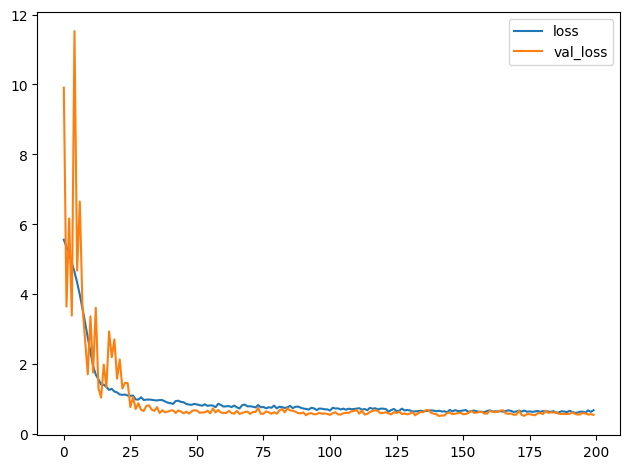

In [4]:
model.compile(
    optimizer='adam',
    loss='mae'
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=200,
)


# Show History
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

You'll typically get better performance if you standardize your data before using it for training. That we were able to use the raw data at all, however, shows how effective batch normalization can be on more difficult datasets.